# 모델2 : 맥동성

## 모델구성
- 레거시모델과 가장 유사하게 모델 구성
- 데이터 표준화

## 결과
- 기존모델의 성능
  - Epoch : 10 , lr : 0.001
  - Train Loss : 1.014
  - Test Accuracy = 0.976
  - Test Precision = 0.926
  - Test Recall = 0.789
  - Test F1 = 0.852
- 모델링 결과
  - Test Loss : 0.072 / Recall : 0.839
- 평가
  - 훈련점수와 검증점수의 차이가 없어 과소적합이 의심됨
  - 성능을 올리기 위하여 복잡도를 증가시키는 방향의 개선 필요

In [1]:
# Tensorflow Check
import tensorflow as tf
from tensorflow.python.client import device_lib
import sys
print(f'Python     : {sys.version.split("|")[0]}')
print(f'Tensorflow : {tf.__version__}')
print(f'TF GPU     : {"True" if device_lib.list_local_devices()[1] else "False"}')

Python     : 3.10.11 
Tensorflow : 2.10.1
TF GPU     : True


In [2]:
# 필요한 라이브러리 불러오기
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from IPython.display import clear_output
import json

# 각종 변수 선언
csv_path = 'D:/coding/aib/GPTeachersDay/TeamProject1/leeyeonjun/Data/binary_classification_data.csv'
EPOCHS = 1000
MB_SIZE = 1024

In [3]:
# 필요한 함수 / 메소드 정의
class CustomCallback(keras.callbacks.Callback):
    """
    사용자 정의 콜백함수
    """
    def on_train_begin(self, logs=None):
        print("Starting training")

    def on_train_end(self, logs=None):
        print("End training")
        # clear_output(wait=True)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 100 == 0:print()
        if epoch % 10 == 0:
            print(f'{epoch} / ', end='')

def load_data(csv_path, TRAIN_RATIO=0.8):
    global X, y, X_train, X_test, y_train, y_test, df
    
    # 데이터셋 로드
    df = pd.read_csv(csv_path)
    
    # 학습 데이터 분리
    X = df.drop('target_class', axis=1)
    y = df['target_class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_RATIO, random_state = 83)
    
    # 표준화
    scaler = StandardScaler() 
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_train = pd.DataFrame(X_train, columns=X.columns)
    X_test = pd.DataFrame(X_test, columns=X.columns)

def get_model(shape, node_n=8, dout=0.0001):
    inputs  = keras.Input(shape=shape)
    
    dense1  = keras.layers.Dense(node_n)(inputs)
    norm1   = keras.layers.BatchNormalization()(dense1)
    relu1   = keras.layers.Activation('relu')(norm1)
    dout1   = keras.layers.Dropout(dout)(relu1)
    
    dense2  = keras.layers.Dense(node_n)(dout1)
    norm2   = keras.layers.BatchNormalization()(dense2)
    relu2   = keras.layers.Activation('relu')(norm2)
    dout2   = keras.layers.Dropout(dout)(relu2)
    
    outputs = keras.layers.Dense(1, activation='sigmoid')(dout2)
    model   = keras.Model(inputs, outputs, name='Star_Model')
    
    METRICS = [
            keras.metrics.TruePositives(name='tp'),
            keras.metrics.FalsePositives(name='fp'),
            keras.metrics.TrueNegatives(name='tn'),
            keras.metrics.FalseNegatives(name='fn'), 
            keras.metrics.BinaryAccuracy(name='accuracy'),
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc'),
            keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
            ]
    
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=METRICS
        )
    return model

In [4]:
load_data(csv_path)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X_train.describe()

(14318, 8) (3580, 8) (14318,) (3580,)


,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve
count,1.431800e+04,1.431800e+04,1.431800e+04,1.431800e+04,1.431800e+04,1.431800e+04,14318.000000,1.431800e+04
mean,4.937771e-17,1.985033e-17,4.168570e-17,1.215833e-17,2.679795e-17,4.081725e-17,0.000000,6.252855e-17
std,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035,1.000035e+00
min,-4.120136e+00,-3.207467e+00,-2.235779e+00,-5.770065e-01,-4.188843e-01,-9.702420e-01,-2.481473,-1.010623e+00
25%,-4.023072e-01,-6.137926e-01,-4.266299e-01,-3.186363e-01,-3.605269e-01,-6.075160e-01,-0.564632,-6.588786e-01
50%,1.541275e-01,6.343979e-02,-2.415434e-01,-2.553492e-01,-3.306753e-01,-4.016201e-01,0.028258,-2.053026e-01
75%,6.282295e-01,6.600747e-01,-6.613046e-04,-1.334971e-01,-2.407483e-01,1.029766e-01,0.531815,3.272613e-01
max,3.198297e+00,6.588416e+00,7.212419e+00,1.092778e+01,6.832434e+00,4.346189e+00,5.834657,1.022672e+01


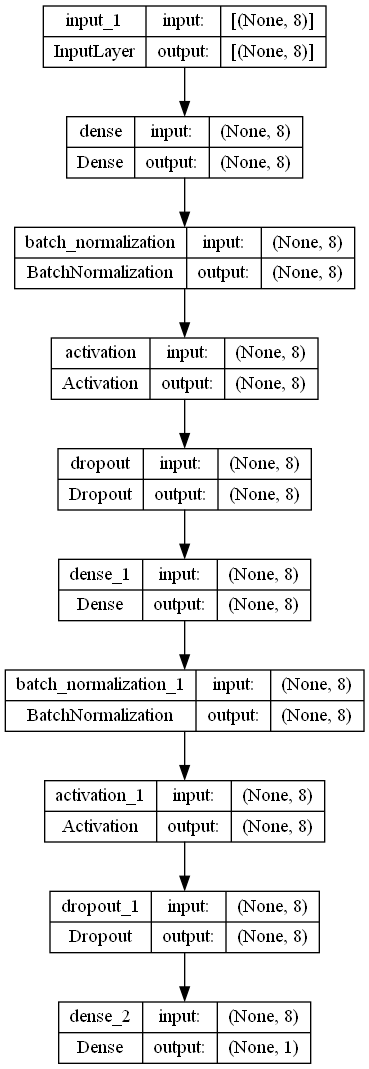

In [5]:
model = get_model(len(X_train.columns))
keras.utils.plot_model(model, show_shapes=True, to_file='model2_model.png')

In [6]:
# 얼리스타핑
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss'
                                        , min_delta=0.000001
                                        , mode='min'
                                        , patience=EPOCHS//2)

# 모델 저장
checkpoint_path = 'model2.h5'
checkpoint = keras.callbacks.ModelCheckpoint(
                                        checkpoint_path
                                        , monitor='val_loss'
                                        , verbose=0
                                        , save_best_only=True
                                        , save_weights_only=True)

# 모델 학습
history = model.fit(X_train, y_train
                , batch_size=MB_SIZE
                , validation_split = 0.2
                , verbose=0
                , epochs=EPOCHS
                , callbacks=[earlystop, checkpoint, CustomCallback()]
                )

# 가장 성능이 좋았던 모델을 가져와 평가
model.load_weights(checkpoint_path)
results = model.evaluate(X_test, y_test)
print(f'Test Loss : {results[0]:.3f} / Recall : {results[7]:.3f}')

Starting training

0 / 10 / 20 / 30 / 40 / 50 / 60 / 70 / 80 / 90 / 
100 / 110 / 120 / 130 / 140 / 150 / 160 / 170 / 180 / 190 / 
200 / 210 / 220 / 230 / 240 / 250 / 260 / 270 / 280 / 290 / 
300 / 310 / 320 / 330 / 340 / 350 / 360 / 370 / 380 / 390 / 
400 / 410 / 420 / 430 / 440 / 450 / 460 / 470 / 480 / 490 / 
500 / 510 / 520 / 530 / 540 / 550 / 560 / 570 / 580 / 590 / 
600 / 610 / 620 / 630 / 640 / 650 / 660 / 670 / 680 / 690 / 
700 / 710 / 720 / 730 / 740 / 750 / 760 / 770 / 780 / 790 / 
800 / 810 / 820 / 830 / 840 / 850 / 860 / 870 / 880 / 890 / 
900 / 910 / 920 / 930 / 940 / 950 / 960 / 970 / 980 / 990 / End training
112/112 [==============================] - 1s 10ms/step - loss: 0.0719 - tp: 286.0000 - fp: 17.0000 - tn: 3222.0000 - fn: 55.0000 - accuracy: 0.9799 - precision: 0.9439 - recall: 0.8387 - auc: 0.9703 - prc: 0.9332
Test Loss : 0.072 / Recall : 0.839


In [7]:
import json
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist = hist.set_index('epoch')
hist.to_json('model2.json')

with open('model2.json') as json_file:
    json_file = json.loads(json_file.read())
model1_hist = pd.DataFrame(json_file)
model1_hist

,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc,val_loss,val_tp,val_fp,val_tn,val_fn,val_accuracy,val_precision,val_recall,val_auc,val_prc
0,1.042941,1026.0,10205.0,222.0,1.0,0.108958,0.091354,0.999026,0.711310,0.189956,0.826930,268.0,2208.0,385.0,3.0,0.228003,0.108239,0.988930,0.712893,0.169174
1,0.955159,1025.0,9699.0,728.0,2.0,0.153047,0.095580,0.998053,0.784852,0.345963,0.781725,268.0,2008.0,585.0,3.0,0.297835,0.117750,0.988930,0.801264,0.333182
2,0.876594,1022.0,8997.0,1430.0,5.0,0.214074,0.102006,0.995131,0.833058,0.524194,0.741188,265.0,1787.0,806.0,6.0,0.373953,0.129142,0.977860,0.858432,0.530184
3,0.807169,1016.0,8052.0,2375.0,11.0,0.296054,0.112042,0.989289,0.869068,0.645581,0.704110,263.0,1531.0,1062.0,8.0,0.462640,0.146600,0.970480,0.897213,0.658360
4,0.745783,999.0,6832.0,3595.0,28.0,0.401083,0.127570,0.972736,0.894786,0.718764,0.669758,258.0,1137.0,1456.0,13.0,0.598464,0.184946,0.952030,0.927048,0.742169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.061171,896.0,85.0,10342.0,131.0,0.981142,0.913354,0.872444,0.985249,0.941166,0.056816,242.0,25.0,2568.0,29.0,0.981145,0.906367,0.892989,0.990290,0.956139
996,0.060599,894.0,85.0,10342.0,133.0,0.980967,0.913177,0.870497,0.984237,0.940090,0.056907,242.0,25.0,2568.0,29.0,0.981145,0.906367,0.892989,0.990280,0.955967
997,0.061317,888.0,79.0,10348.0,139.0,0.980967,0.918304,0.864654,0.983873,0.940645,0.056844,241.0,24.0,2569.0,30.0,0.981145,0.909434,0.889299,0.990289,0.955851
998,0.061276,892.0,82.0,10345.0,135.0,0.981055,0.915811,0.868549,0.985217,0.938895,0.056739,242.0,24.0,2569.0,29.0,0.981494,0.909774,0.892989,0.990389,0.956257


112/112 [==============================] - 0s 3ms/step


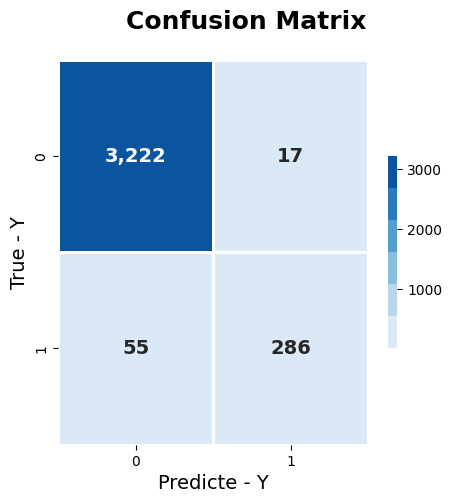

In [8]:
c_mat = confusion_matrix(y_test, model.predict(X_test).round())

# 히트맵을 그린다
fig, ax = plt.subplots(figsize=(5,5))
fig.suptitle('Confusion Matrix', fontsize = 18, fontweight = 'bold')
sns.heatmap(c_mat, 
            cmap = sns.color_palette('Blues'), 
            annot = True,
            annot_kws = {'fontweight':'bold','size':14},
            fmt=',.0f',
            linewidths = 2,
            cbar_kws = {'shrink': .5},
           )

plt.xlabel('Predicte - Y', fontsize = 14)
plt.ylabel('True - Y', fontsize = 14)
plt.show()

fig.savefig('model2_cm.png', dpi=80, bbox_inches='tight')

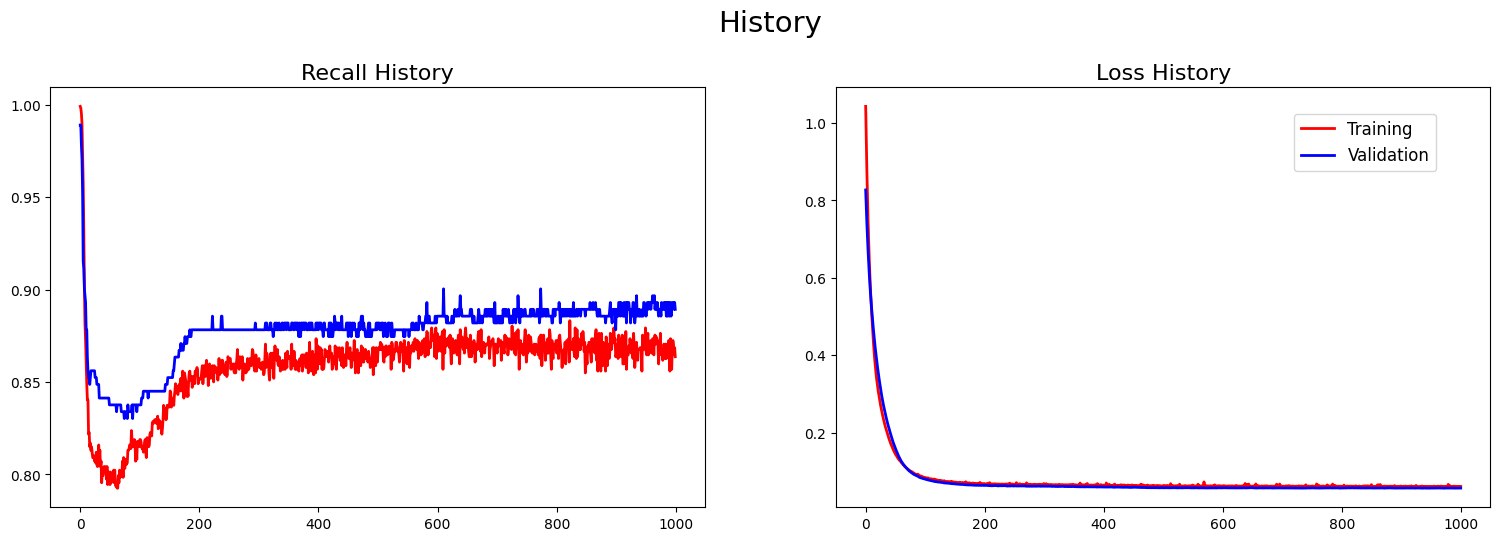

In [9]:
fig = plt.figure(figsize=(16, 6))
fig.suptitle('History', fontsize = 21)

# Recall Plot
ax = plt.subplot(1, 2, 1)
plt.title(f'Recall History', fontsize = 16, y = 1)
plt.plot(history.history["recall"], color='r', linewidth=2, label="Training")
plt.plot(history.history["val_recall"], color='b', linewidth=2, label="Validation")

# Loss Plot
ax = plt.subplot(1, 2, 2)
plt.title(f'Loss History', fontsize = 16, y = 1)
plt.plot(history.history["loss"], color='r', linewidth=2, label="Training")
plt.plot(history.history["val_loss"], color='b', linewidth=2, label="Validation")

plt.legend(fontsize=12, loc=(0.7, 0.8))
plt.subplots_adjust(right=0.95, left=0.05, top=0.85, bottom=0.15, wspace=0.2, hspace=0.2)
plt.show()

fig.savefig('model2_history.png', dpi=80, bbox_inches='tight')